# Part 3: Learning Algorithms: Support Vector Machine

## Support Vector Machines

---------
Support Vector Machines are said to be the most popular and widely used algorithm. The concept behind SVM is so simple that once you read [Andrew Ng's notes here](https://www.reddit.com/r/MachineLearning/comments/15zrpp/please_explain_support_vector_machines_svm_like_i/), you will fairly understand how to implement it. I'd recommend going deep into SVM. But there are other awesome articles too, like [this](https://machinelearningmastery.com/support-vector-machines-for-machine-learning/) and [this](https://www.quora.com/What-does-support-vector-machine-SVM-mean-in-laymans-terms) and [this too](https://www.reddit.com/r/MachineLearning/comments/15zrpp/please_explain_support_vector_machines_svm_like_i/). 

I've enjoyed reading these articles. Now, let me tell you what SVM is.
Suppose you have training data of positive and negative examples( Positive: Person has Cancer & Negative: Persons doesn't have cancer). You want to classify this data and predict if it's a positive or negative example. We plot the decision boundary using the [equation](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html):

$$\Theta^T x = \ 0$$

This is basically a line for two-dimensional data. If we have certain positive training data that are far away from this line, we can predict that it is a positive example with more confidence. And if it's closer to this line, then we can predict it as positive example but a small change in decision boundary or line can change our prediction. 

#### Let's import our required libraries and dataset

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict #In python, from sklearn.cross_validation import cross_val_predict
import re

**Let's prepare our data** 

Here, we will consider 8 classes out of 20. We will merge four of those into 'Computer Technology' and the other four into 'Recreational activity'. Our new classes will be 'Computer Technology' and 'Recreational activity'. 
Look at the code below to understand what I mean.

* We will also separate the training and test subsets of the data. Model will learn on training data. We will test this model on test data.

In [6]:
#getting data
computer_subclass=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
rec_subclass=['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']  
comp_train=fetch_20newsgroups(subset='train',categories=computer_subclass,shuffle=True,random_state=42,
                              remove=('headers','footers','quotes'))
rec_train=fetch_20newsgroups(subset='train',categories=rec_subclass,shuffle=True,random_state=42,
                             remove=('headers','footers','quotes'))
comp_test=fetch_20newsgroups(subset='test',categories=computer_subclass,shuffle=True,random_state=42,
                             remove=('headers','footers','quotes'))
rec_test=fetch_20newsgroups(subset='test',categories=rec_subclass,shuffle=True,random_state=42,
                            remove=('headers','footers','quotes'))
all_data=comp_train.data+comp_test.data+rec_train.data+rec_test.data

**Since SVM is a supervised learning algorithm, we will need labels. So, we will label the data before training the classification model. We will use [+1, -1] classification. '+1' for 'Computer Technology' and '-1' for 'Recreational Activity' classes.**

In [7]:
classification_train=[1]*len(comp_train.data)+[-1]*len(rec_train.data)
classification_test=[1]*len(comp_test.data)+[-1]*len(rec_test.data)

**Preprocessing the data**

We have learnt how to do this before in Part_1 and Part_2

In [8]:
stemmer=SnowballStemmer("english")
#preprocessing data
punctuations='[! \" # $ % \& \' \( \) \ * + , \- \. \/ : ; <=> ? @ \[ \\ \] ^ _ ` { \| } ~]'
def preprocessing(data_list):
    for i in range(len(data_list)):
        data_list[i]=" ".join([stemmer.stem(data) for data in re.split(punctuations,data_list[i])])
        data_list[i]=data_list[i].replace('\n','').replace('\t','').replace('\r','')
preprocessing(all_data)

**We will now tokenize the documents and create a TFIDF matrix, which will be sparse. We will also reduce the dimensions of the features to 50 using LSI and NMF**

min_df = 2

In [9]:
count_vect=CountVectorizer(min_df=2,stop_words ='english')
X_counts=count_vect.fit_transform(all_data)

#Feature extraction using TFxIDF
tfidf_transformer=TfidfTransformer()
X_tfidf=tfidf_transformer.fit_transform(X_counts)

#Dimensionality reduction using LSI
svd=TruncatedSVD(n_components=50,n_iter=10,random_state=42)
svd.fit(X_tfidf)
LSI_SVD=svd.transform(X_tfidf)

#Dimensionality reduction using NMF
from sklearn.decomposition import NMF
model=NMF(n_components=50,init='random',random_state=0)
LSI_NMF=model.fit_transform(X_tfidf)
# print(LSI.shape)



### Linear SVM with SVD

In [68]:
#Split train and testing datasts
split_point_1=len(comp_train.data)
split_point_2=split_point_1+len(comp_test.data)
split_point_3=split_point_2+len(rec_train.data)

LSI_test_SVD=np.concatenate((LSI_SVD[split_point_1 : split_point_2],LSI_SVD[split_point_3:]))
LSI_train_SVD=np.concatenate((LSI_SVD[0:split_point_1],LSI_SVD[split_point_2:split_point_3]))


We will first create instance of LinearSVM model. Then we will fit the model on training data(LSI_train_SVD)using fit method.

In [69]:
#Prediction using Linear SVM
classifier=svm.LinearSVC()
classifier.fit(LSI_train_SVD,classification_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

The model has now learnt from the training data. (Just a few lines of code...)

Now, it's time to test our model, using predict method of classifier.

We will also calculate the confidence score (distance of data from hyperplane), using decision_function.

In [70]:
predicted_class_SVD=classifier.predict(LSI_test_SVD)
actual_class=classification_test
score_SVD=classifier.decision_function(LSI_test_SVD)

We will print our Classification report to see what we have got.

We can easily get classification report from metrics library of sklearn. We need to pass in the following arguments: our predicted results and actual results.

What do we get in Classification report? 
* Precision: It is the proportion of the items places in the category that are really in the category.
* Recall: It is the proportion of the iterms reallin in the category that are placed in the category.
* F1-score: It is the harmonic mean of precision and recall
* Support: I don't know what support is.

In [71]:
print('Classification report for Linear SVM using SVD:')
print(metrics.classification_report(actual_class,predicted_class_SVD,target_names=["Com Tech","Rec Act"]))

Classification report for Linear SVM using SVD:
              precision    recall  f1-score   support

    Com Tech       0.91      0.97      0.94      1590
     Rec Act       0.97      0.90      0.93      1560

   micro avg       0.94      0.94      0.94      3150
   macro avg       0.94      0.94      0.94      3150
weighted avg       0.94      0.94      0.94      3150



Confusion matrix

In [72]:
print('Confusion Matrix for Linear SVM with SVD:')
print(metrics.confusion_matrix(actual_class,predicted_class_SVD))

Confusion Matrix for Linear SVM with SVD:
[[1544   46]
 [ 153 1407]]


Total Accuracy for Linear SVM with SVD:

In [73]:
print('Total accuracy: ')
print(np.mean(actual_class==predicted_class_SVD))

Total accuracy: 
0.9368253968253968


We will plot now ROC curve

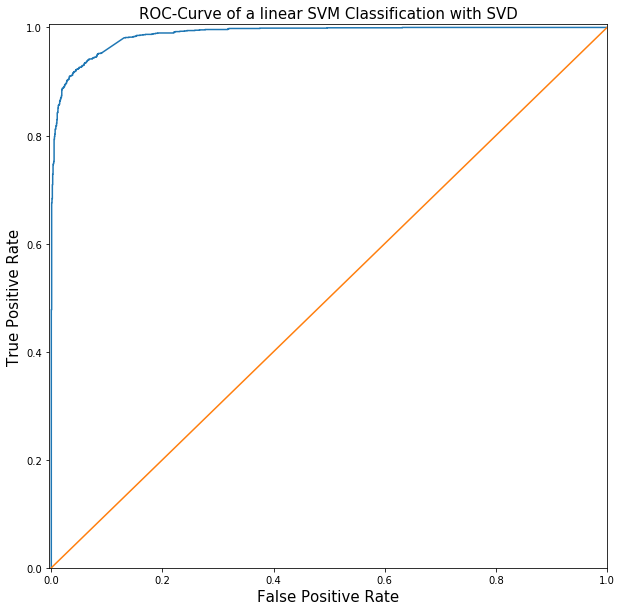

In [74]:
fpr,tpr,threshold=roc_curve(actual_class,score_SVD)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of a linear SVM Classification with SVD',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

## Linear SVM with NMF

In [76]:
#Split train and testing datasts
split_point_1=len(comp_train.data)
split_point_2=split_point_1+len(comp_test.data)
split_point_3=split_point_2+len(rec_train.data)

LSI_test_NMF=np.concatenate((LSI_NMF[split_point_1 : split_point_2],LSI_NMF[split_point_3:]))
LSI_train_NMF=np.concatenate((LSI_NMF[0:split_point_1],LSI_NMF[split_point_2:split_point_3]))

We will first create instance of LinearSVM model. Then we will fit the model on training data(LSI_train_NMF)using fit method.

In [77]:
#Prediction using Linear SVM
classifier=svm.LinearSVC()
classifier.fit(LSI_train_NMF,classification_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

The model has now learnt from the training data. (Just a few lines of code...)

Now, it's time to test our model, using predict method of classifier.

We will also calculate the confidence score (distance of data from hyperplane), using decision_function.

In [103]:
predicted_class_NMF=classifier.predict(LSI_test_NMF)
actual_class=classification_test
score_NMF=classifier.decision_function(LSI_test_NMF)
#print('Predicted: {}'.format(predicted_class_NMF))
#print('Actual: {}'.format(classification_test))
#print(len(predicted_class_NMF))

#print(len(actual_class))
df1 = pd.DataFrame({'predicted':predicted_class_NMF, 'actual': actual_class, 'Matched?': predicted_class_NMF == actual_class},
             index=range(0,len(predicted_class_NMF)))
accuracy = df1['Matched?'].sum()/len(actual_class)
accuracy

0.8873015873015873

We will print our Classification report to see what we have got.

We can easily get classification report from metrics library of sklearn. We need to pass in the following arguments: our predicted results and actual results.

What do we get in Classification report? 
* Precision: It is the proportion of the items places in the category that are really in the category.
* Recall: It is the proportion of the iterms reallin in the category that are placed in the category.
* F1-score: It is the harmonic mean of precision and recall
* Support: I don't know what support is.

In [79]:
print('Classification report for Linear SVM using NMF:')
print(metrics.classification_report(actual_class,predicted_class_NMF,target_names=["Com Tech","Rec Act"]))

Classification report for Linear SVM using NMF:
              precision    recall  f1-score   support

    Com Tech       0.84      0.95      0.90      1590
     Rec Act       0.95      0.82      0.88      1560

   micro avg       0.89      0.89      0.89      3150
   macro avg       0.89      0.89      0.89      3150
weighted avg       0.89      0.89      0.89      3150



Confusion matrix

In [80]:
print('Confusion Matrix for Linear SVM with NMF:')
print(metrics.confusion_matrix(actual_class,predicted_class_NMF))

Confusion Matrix for Linear SVM with NMF:
[[1516   74]
 [ 281 1279]]


Total Accuracy for Linear SVM with NMF:

In [81]:
print('Total accuracy: ')
print(np.mean(actual_class==predicted_class_NMF))

Total accuracy: 
0.8873015873015873


We will plot now ROC curve

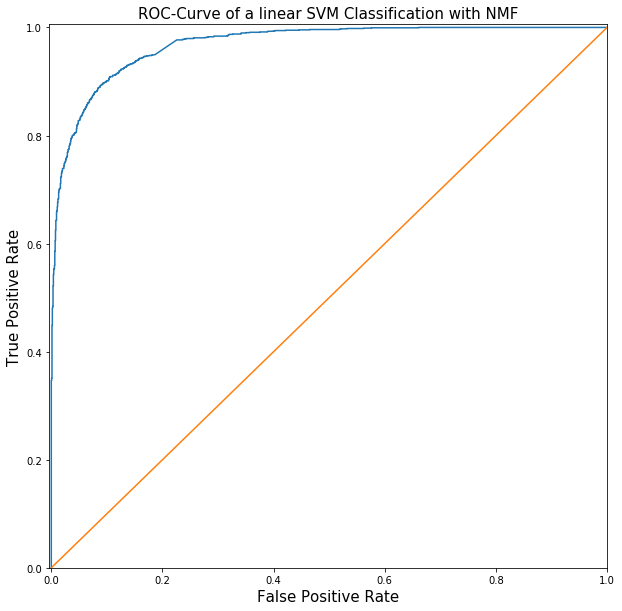

In [82]:
fpr,tpr,threshold=roc_curve(actual_class,score)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of a linear SVM Classification with NMF',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

**As we can see that LSI performs better than NMF with linear SVM model.**

## Hard Margin and Soft Margin SVM

When gamma is high, you get high bias and low variance.

When gamma is low, you get high variance and low bias.

In [104]:
#Classification report (and plotting ROC curves) using Soft Margin and Hard Margin SVMs 
classification_all=[1]*(len(comp_train.data)+len(comp_test.data))+[-1]*(len(rec_train.data)+len(rec_test.data))

SVM with SVD

Gamma=0.001
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.50      1.00      0.67      3979
     Rec Act       0.00      0.00      0.00      3903

   micro avg       0.50      0.50      0.50      7882
   macro avg       0.25      0.50      0.34      7882
weighted avg       0.25      0.50      0.34      7882

Confusion Matrix:
[[3979    0]
 [3903    0]]
Total accuracy: 
0.5048211113930474


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


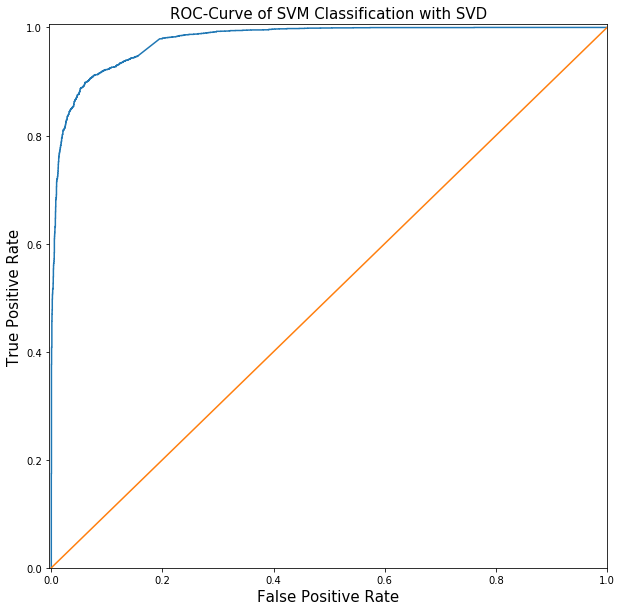

Gamma=1000
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.76      0.14      0.24      3979
     Rec Act       0.52      0.95      0.68      3903

   micro avg       0.54      0.54      0.54      7882
   macro avg       0.64      0.55      0.46      7882
weighted avg       0.64      0.54      0.46      7882

Confusion Matrix:
[[ 570 3409]
 [ 178 3725]]
Total accuracy: 
0.5449124587668105


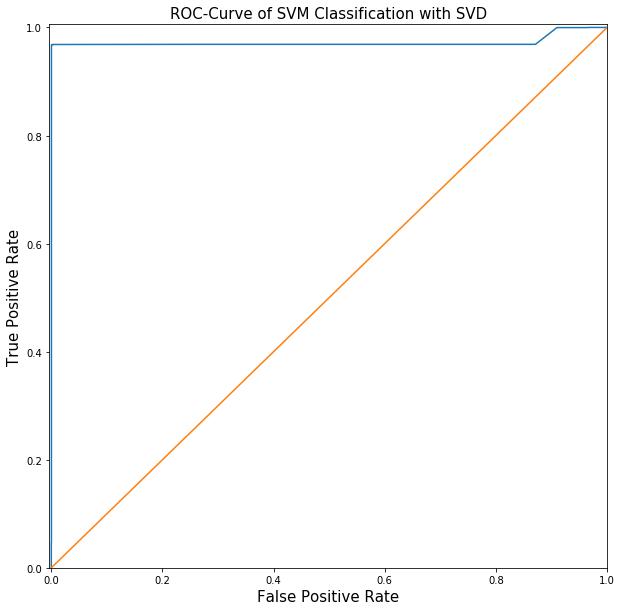

In [106]:
for gamma_value in [0.001,1000]:
    classifier=svm.SVC(gamma=gamma_value)
    classifier.fit(LSI_SVD,classification_all)
    predicted_class_SVD= cross_val_predict(classifier,LSI_SVD,classification_all,cv=5)
    score_SVD=classifier.decision_function(LSI_SVD)

    print('Gamma='+str(gamma_value))
    print('Classification report:')
    print(metrics.classification_report(classification_all,predicted_class_SVD,target_names=["Com Tech","Rec Act"]),)
    
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(classification_all,predicted_class_SVD))
    
    print('Total accuracy: ')
    print(np.mean(predicted_class_SVD==classification_all))
    
    fpr,tpr,threshold=roc_curve(classification_all,score_SVD)
    line=[0,1]
    plt.figure(figsize=(10,10))
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1])
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.title('ROC-Curve of SVM Classification with SVD',fontsize=15)
    plt.axis([-0.004,1,0,1.006])
    plt.show()

SVM with NMF

Gamma=0.001
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.50      1.00      0.67      3979
     Rec Act       0.00      0.00      0.00      3903

   micro avg       0.50      0.50      0.50      7882
   macro avg       0.25      0.50      0.34      7882
weighted avg       0.25      0.50      0.34      7882

Confusion Matrix:
[[3979    0]
 [3903    0]]
Total accuracy: 
0.5048211113930474


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


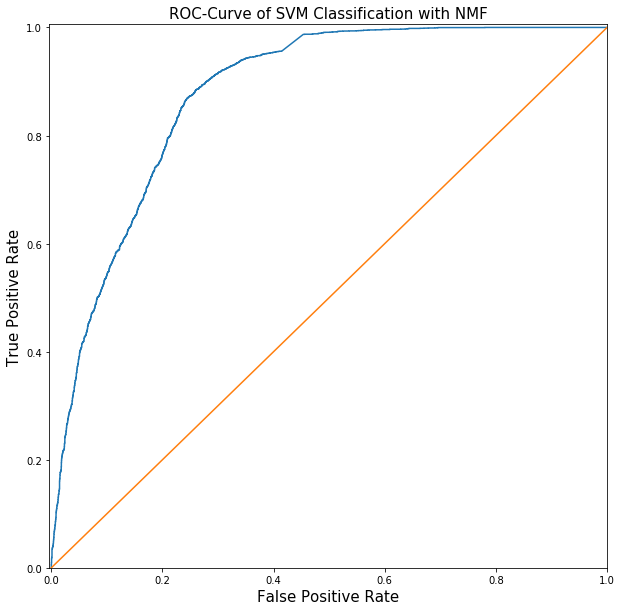

Gamma=1000
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.90      0.82      0.86      3979
     Rec Act       0.83      0.91      0.87      3903

   micro avg       0.86      0.86      0.86      7882
   macro avg       0.87      0.86      0.86      7882
weighted avg       0.87      0.86      0.86      7882

Confusion Matrix:
[[3260  719]
 [ 364 3539]]
Total accuracy: 
0.8625983252981477


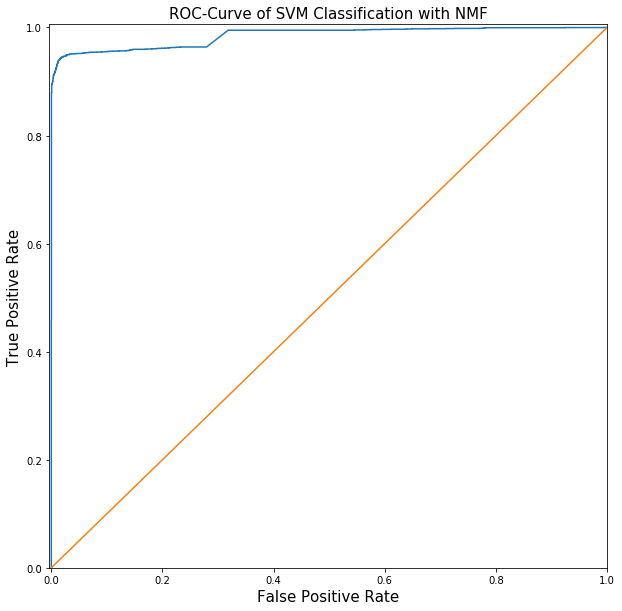

In [107]:
for gamma_value in [0.001,1000]:
    classifier=svm.SVC(gamma=gamma_value)
    classifier.fit(LSI_NMF,classification_all)
    predicted_class_NMF= cross_val_predict(classifier,LSI_NMF,classification_all,cv=5)
    score_NMF=classifier.decision_function(LSI_NMF)

    print('Gamma='+str(gamma_value))
    print('Classification report:')
    print(metrics.classification_report(classification_all,predicted_class_NMF,target_names=["Com Tech","Rec Act"]),)
    
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(classification_all,predicted_class_NMF))
    
    print('Total accuracy: ')
    print(np.mean(predicted_class_NMF==classification_all))
    
    fpr,tpr,threshold=roc_curve(classification_all,score_NMF)
    line=[0,1]
    plt.figure(figsize=(10,10))
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1])
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.title('ROC-Curve of SVM Classification with NMF',fontsize=15)
    plt.axis([-0.004,1,0,1.006])
    plt.show()

It is observed that NMF performs better than LSI when we use soft margin and hard margin SVM.

But, overall, Linear SVM performs better than Soft Margin and Hard Margin SVM because it selects optimal value of gamma on its own.

**We need to find optimal value of gamma**

    We will be using five-fold cross-validation. You can learn more about what's 5-fold cross-validation [here]

SVM with SVD

In [108]:
#Comparing the results for the set of gamma values, and finding the best gamma using 5-fold cross validation
for gamma_value in [0.001,0.01,0.1,1,10,100,1000]:
    classifier=svm.SVC(gamma=gamma_value)
    classifier.fit(LSI_SVD,classification_all)
    predicted_class_SVD= cross_val_predict(classifier,LSI_SVD,classification_all,cv=5)
    
    print('Gamma='+str(gamma_value))
    print('Classification report:')
    print(metrics.classification_report(classification_all,predicted_class_SVD,target_names=["Com Tech","Rec Act"]),)
    
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(classification_all,predicted_class_SVD))
    
    print('Total accuracy: ')
    print(np.mean(predicted_class_SVD==classification_all))
    print('\n\n')

Gamma=0.001
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.50      1.00      0.67      3979
     Rec Act       0.00      0.00      0.00      3903

   micro avg       0.50      0.50      0.50      7882
   macro avg       0.25      0.50      0.34      7882
weighted avg       0.25      0.50      0.34      7882

Confusion Matrix:
[[3979    0]
 [3903    0]]
Total accuracy: 
0.5048211113930474





C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gamma=0.01
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.78      0.99      0.87      3979
     Rec Act       0.99      0.72      0.83      3903

   micro avg       0.85      0.85      0.85      7882
   macro avg       0.88      0.85      0.85      7882
weighted avg       0.88      0.85      0.85      7882

Confusion Matrix:
[[3939   40]
 [1107 2796]]
Total accuracy: 
0.8544785587414362



Gamma=0.1
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.87      0.98      0.92      3979
     Rec Act       0.98      0.85      0.91      3903

   micro avg       0.91      0.91      0.91      7882
   macro avg       0.92      0.91      0.91      7882
weighted avg       0.92      0.91      0.91      7882

Confusion Matrix:
[[3901   78]
 [ 600 3303]]
Total accuracy: 
0.9139812230398376



Gamma=1
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.90  

With increase in gamma value, there was initially an increase in accuracy since this was the case of underfitting, and thereafter, at gamma =10, accuracy peaked. After that, when gamma became large, accuracy decreases because of overfitting.

SVM with NMF

In [ ]:
#Comparing the results for the set of gamma values, and finding the best gamma using 5-fold cross validation
for gamma_value in [0.001,0.01,0.1,1,10,100,1000]:
    classifier=svm.SVC(gamma=gamma_value)
    classifier.fit(LSI_NMF,classification_all)
    predicted_class_NMF= cross_val_predict(classifier,LSI_NMF,classification_all,cv=5)
    
    print('Gamma='+str(gamma_value))
    print('Classification report:')
    print(metrics.classification_report(classification_all,predicted_class_NMF,target_names=["Com Tech","Rec Act"]),)
    
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(classification_all,predicted_class_NMF))
    
    print('Total accuracy: ')
    print(np.mean(predicted_class_NMF==classification_all))
    print('\n\n')

Gamma=0.001
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.50      1.00      0.67      3979
     Rec Act       0.00      0.00      0.00      3903

   micro avg       0.50      0.50      0.50      7882
   macro avg       0.25      0.50      0.34      7882
weighted avg       0.25      0.50      0.34      7882

Confusion Matrix:
[[3979    0]
 [3903    0]]
Total accuracy: 
0.5048211113930474





C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gamma=0.01
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.50      1.00      0.67      3979
     Rec Act       0.00      0.00      0.00      3903

   micro avg       0.50      0.50      0.50      7882
   macro avg       0.25      0.50      0.34      7882
weighted avg       0.25      0.50      0.34      7882

Confusion Matrix:
[[3979    0]
 [3903    0]]
Total accuracy: 
0.5048211113930474





C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gamma=0.1
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.61      0.96      0.75      3979
     Rec Act       0.91      0.37      0.53      3903

   micro avg       0.67      0.67      0.67      7882
   macro avg       0.76      0.67      0.64      7882
weighted avg       0.76      0.67      0.64      7882

Confusion Matrix:
[[3830  149]
 [2452 1451]]
Total accuracy: 
0.6700076122811469



Gamma=1
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.81      0.96      0.88      3979
     Rec Act       0.95      0.76      0.85      3903

   micro avg       0.86      0.86      0.86      7882
   macro avg       0.88      0.86      0.86      7882
weighted avg       0.88      0.86      0.86      7882

Confusion Matrix:
[[3838  141]
 [ 926 2977]]
Total accuracy: 
0.8646282669373255



Gamma=10
Classification report:
              precision    recall  f1-score   support

    Com Tech       0.88    

Similar trend is observed for NMF. SVD performs better than NMF.